In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

### En este caso el modelo que mejor funcionó en las pruebas fue el 5to:  La regresion logistica utilizando todos los datos. No obstante, el modelo 1 (usando las primeras 10 columnas, las mean) tambien tiene un gran rendimiento en proporcion a la cantidad de datos suministrados (97% vs 100%)

In [2]:
data = load_breast_cancer()
print (data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [3]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform (data.data[:,:10]) # elijo las primeras 10 columnas (las 'mean')
Y = data.target

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [6]:
class LogisticRegressor():
    
    def __init__ (self, nCols): 
        """ Inicializo modelo """
        self.w = np.zeros(nCols)
        self.b = 0
        self.n_features = nCols
        self.loss_progress = []
    
    def compute_gradient (self, X, Y):
        """ Return dW y dB, despues de las 'm' iteraciones """
        m, n = X.shape
        sum_dB = .0
        sum_dW = np.zeros(n)

        for i in range (m):
            sum_dB += self.predict(X[i])- Y[i] # dB_i
            for j in range(n):
                sum_dW[j] += (self.predict(X[i])- Y[i]) * X[i][j] # dW_ij
        
        dB = sum_dB / m
        dW = sum_dW / m
        
        return dW, dB
        
    def compute_loss (self, y, preds):
        """ 
        Return error medio (1/m)*Sum([error(xi, yi) for i in range(m)])
        """
        m = y.shape[0]
        error_i = lambda gi, yi: - yi*np.log(gi) - (1-yi)*np.log(1-gi)
        return (1/m) * sum([error_i(preds[i], y[i]) for i in range(m)]) 
    
    def sigmoid (self, z):
        return 1 / (1+np.e**(-z))
    
    def predict (self, X, threshold=0.5, wThreshold=False):
        """ Return float g(f(x)) o (m, ) float array"""
        dim = X.ndim
        if dim > 1:
            m = X.shape[0]
            ret = np.zeros(m)
            for i in range(m):
                z_i = self.w @ X[i] + self.b
                if wThreshold:
                    ret[i] = self.sigmoid (z_i) >= 0.5
                else:
                    ret[i] = self.sigmoid (z_i)
            return ret
        else:
            z = np.dot(self.w, X) + self.b
            if wThreshold:
                return self.sigmoid (z) >= 0.5
            else:
                return self.sigmoid (z)
            
    
    def fit (self, X, Y, l_rate=0.05, n_epochs=1000, verb=False):
        for n in range(n_epochs):
            dW, dB = self.compute_gradient (X, Y)
            self.w -= l_rate * dW
            self.b -= l_rate * dB
            preds = self.predict(X)
            nLoss = self.compute_loss(Y, preds)
            self.loss_progress.append(nLoss)
            if n % 100 == 0: print (f"{n}* epoch: {nLoss}")
        print (f"* Modelo entrenado. Internal Last Error (train_data): {self.loss_progress[-1]}")
        if verb:
            plt.plot(list(range(0, n_epochs)), self.loss_progress)
            plt.title(f"Loss history w/ l_rate:{l_rate}")
            plt.show()

## MODELO 1 (97.4%) [mean_cols]

0* epoch: 0.6186332823038769
100* epoch: 0.1833451949041051
200* epoch: 0.16446704023810535
300* epoch: 0.15729731111162873
400* epoch: 0.15346201975025983
500* epoch: 0.1510677140076375
600* epoch: 0.14943240740794375
700* epoch: 0.14824689867635996
800* epoch: 0.1473499619315119
900* epoch: 0.14664910017918378
* Modelo entrenado. Internal Last Error (train_data): 0.1460924524881229


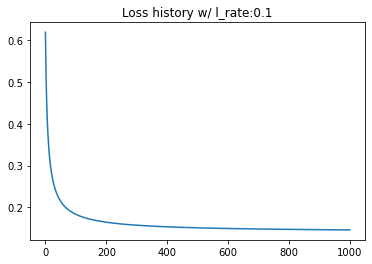

In [7]:
logReg = LogisticRegressor(x_train.shape[1])

# error inicial
test_preds = logReg.predict(x_test)
initial_error = logReg.compute_loss(y_test, test_preds)

logReg.fit(x_train, y_train, l_rate=0.1, verb=True)

In [8]:
# Pruebo con test_data
test_preds = logReg.predict(x_test)
final_error = logReg.compute_loss(y_test, test_preds)
round(initial_error, 3), round (final_error, 3)

(0.693, 0.103)

In [9]:
# Modelo 1: usando las primeras 10 columnas (mean)
modelo1 = logReg 
print('Modelo 1 (test accuracy): %f'%(np.mean(modelo1.predict(x_test, wThreshold=True) == y_test) * 100))

Modelo 1 (test accuracy): 97.368421


## MODELO 2 (91.2%) [error cols]

In [10]:
## Modelo 2: usando columnas 10 a 20 (error)
X2 = ss.fit_transform (data.data[:,10:20])
x_train, x_test, y_train, y_test = train_test_split(X2, Y, train_size=0.8)

modelo2 = LogisticRegressor(x_train.shape[1])
modelo2.fit(X2, Y)

test_preds = modelo2.predict(x_test)
final_error = modelo2.compute_loss(y_test, test_preds)

print('Modelo 2 (test accuracy): %f'%(np.mean(modelo2.predict(x_test, wThreshold=True) == y_test) * 100)) 
# menor rendimiento

0* epoch: 0.6779800826570568
100* epoch: 0.390010092559225
200* epoch: 0.3512346503421382
300* epoch: 0.33524753822040193
400* epoch: 0.32615012375992497
500* epoch: 0.32011593695805607
600* epoch: 0.3157476178864943
700* epoch: 0.31239893033503446
800* epoch: 0.3097234613036918
900* epoch: 0.30751643361747705
* Modelo entrenado. Internal Last Error (train_data): 0.3056656208968298
Modelo 2 (test accuracy): 91.228070


## MODELO 3 (84%) [worst cols]

In [11]:
## Modelo 3: usando columnas 20 a 30 (worst)
X3 = ss.fit_transform (data.data[:,20:30])
x_train, x_test, y_train, y_test = train_test_split(X3, Y, train_size=0.8)

modelo3 = LogisticRegressor(x_train.shape[1])
modelo3.fit(X2, Y)

test_preds = modelo3.predict(x_test)
final_error = modelo3.compute_loss(y_test, test_preds)

print('Modelo 3 (test accuracy): %f'%(np.mean(modelo3.predict(x_test, wThreshold=True) == y_test) * 100))
# Modelo1 > Modelo3 > Modelo2

0* epoch: 0.6779800826570568
100* epoch: 0.390010092559225
200* epoch: 0.3512346503421382
300* epoch: 0.33524753822040193
400* epoch: 0.32615012375992497
500* epoch: 0.32011593695805607
600* epoch: 0.3157476178864943
700* epoch: 0.31239893033503446
800* epoch: 0.3097234613036918
900* epoch: 0.30751643361747705
* Modelo entrenado. Internal Last Error (train_data): 0.3056656208968298
Modelo 3 (test accuracy): 84.210526


## MODELO 4 (86.8%) [mean/std error]

In [12]:
# Feature Engineering ? # mean / stderror
m = data.data.shape[0]
X4 = np.zeros([m, 10])

for j in range(10): # 
    val = (data.data[:, 0+j]) / (data.data[:, 10+j])
    X4[:, 0+j] = val

from sklearn.impute import SimpleImputer
si = SimpleImputer()
si.fit_transform(X4)

C:\Users\sebas\AppData\Local\Temp\ipykernel_22952\2442601928.py:6: RuntimeWarning: invalid value encountered in true_divide
  val = (data.data[:, 0+j]) / (data.data[:, 10+j])


array([[16.42922374, 11.46581244, 14.29735708, ...,  9.26906112,
         8.05527806, 12.70951074],
       [37.84728611, 24.21310805, 39.11124191, ...,  5.23656716,
        13.04535637, 16.04473386],
       [26.4082618 , 27.004702  , 28.35332606, ...,  6.21477162,
         9.19555556, 13.12404288],
       ...,
       [36.37160386, 26.12093023, 31.62043796, ...,  3.40526654,
        12.06373293, 14.51181912],
       [28.37465565, 18.38871473, 24.27234927, ...,  9.13461538,
        10.3141136 , 11.34357316],
       [20.11926368, 17.18487395, 18.80690738, ...,  3.9683907 ,
         5.93049327, 21.14265181]])

In [13]:
## Modelo 4: usando feature_engineering:         
m = data.data.shape[0]

X4 = ss.fit_transform (data.data[:,10:20])
x_train, x_test, y_train, y_test = train_test_split(X4, Y, train_size=0.8)

modelo4 = LogisticRegressor(x_train.shape[1])
modelo4.fit(X4, Y)

test_preds = modelo4.predict(x_test)
final_error = modelo4.compute_loss(y_test, test_preds)

print('Modelo 4 (test accuracy): %f'%(np.mean(modelo4.predict(x_test, wThreshold=True) == y_test) * 100))

0* epoch: 0.6779800826570568
100* epoch: 0.390010092559225
200* epoch: 0.3512346503421382
300* epoch: 0.33524753822040193
400* epoch: 0.32615012375992497
500* epoch: 0.32011593695805607
600* epoch: 0.3157476178864943
700* epoch: 0.31239893033503446
800* epoch: 0.3097234613036918
900* epoch: 0.30751643361747705
* Modelo entrenado. Internal Last Error (train_data): 0.3056656208968298
Modelo 4 (test accuracy): 86.842105


## MODELO 5 (100%) [all cols]

In [14]:
# Modelo 5: todos los datos
X5 = ss.fit_transform (data.data)
x_train, x_test, y_train, y_test = train_test_split(X5, Y, train_size=0.8)

modelo5 = LogisticRegressor(x_train.shape[1])
modelo5.fit(X5, Y)

test_preds = modelo5.predict(x_test)
final_error = modelo5.compute_loss(y_test, test_preds)

print('Modelo 5 (test accuracy): %f'%(np.mean(modelo5.predict(x_test, wThreshold=True) == y_test) * 100))

0* epoch: 0.6005808191374273
100* epoch: 0.12940657042719353
200* epoch: 0.10278175008897057
300* epoch: 0.0913020160037522
400* epoch: 0.08456192229465984
500* epoch: 0.08000146472503492
600* epoch: 0.07664914578654126
700* epoch: 0.07404681385420292
800* epoch: 0.07194733613623958
900* epoch: 0.07020446298863492
* Modelo entrenado. Internal Last Error (train_data): 0.06873922660427789
Modelo 5 (test accuracy): 100.000000
